In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statistics

## Structural variant gold set

In [174]:
with open("hsvp.variant.lengths") as file:
    lines = [line.rstrip() for line in file]
sv_lens = list(map(int, lines))

In [175]:
statistics.stdev(sv_lens)

54990.26004894753

In [176]:
np.max(sv_lens)

17373620

In [177]:
np.min(sv_lens)

50

In [178]:
np.mean(sv_lens)

1061.0917464448369

In [179]:
np.median(sv_lens)

164.0

## Inversions from valik

In [180]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

c_darkblue = "#4c6c9c"
c_darkgreen = "#5e8f7b"
c_purple = "#947db0"

In [181]:
def read_stellar_output(filename):
    df = pd.read_csv(filename, sep = "\t", header = None)
    df.drop([1, 2, 7], axis = 1, inplace = True) 
    df.columns = ["dname", "dbegin", "dend", "percid", "strand", "attr"]
    df["len"] = np.abs(df["dend"] - df["dbegin"])
    df[['qname','seq2Range', 'evalue', 'cigar', 'mutations']] = df['attr'].str.split(';',expand=True)
    df[["qbegin", "qend"]] = df["seq2Range"].str.removeprefix("seq2Range=").str.split(',',expand=True)
    df.drop(["cigar", "mutations", "evalue", "attr", "seq2Range"], axis = 1, inplace = True)
    for col in ["dbegin", "dend", "qbegin", "qend"]:
        df[col] = pd.to_numeric(df[col])
    return df

In [182]:
def line_params(best_matches):
    i = 0

    x1 = best_matches["dbegin"].iloc[i]
    x2 = best_matches["dend"].iloc[i]
    y1 = best_matches["qbegin"].iloc[i]
    y2 = best_matches["qend"].iloc[i]

    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    return [a, b]

def get_line(a, b):
    y_line = [0, 14000]
    x_line = []
    for y in y_line:
        x_line.append((y - b) / a)
    return x_line

def plot_matches_on_line(matches, best, x_line, y_line):
    for index, row in matches.iterrows():
        plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-')

    for index, row in best.iterrows():
        plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'r-')

    plt.plot(x_line, y_line, 'y-')
    locs, labels = plt.xticks()

    #plt.xticks(locs, labels, rotation = 20)

    plt.ylim(round(np.min(matches["qbegin"]) - 100), round(np.max(matches["qend"]) + 100))
    plt.xlim(round(np.min(matches["dbegin"]) - 100), round(np.max(matches["dend"]) + 100))
    
    plt.xlabel("GRCh38")
    plt.ylabel(best["qname"].iloc[0])
    plt.title(best["dname"].iloc[0])
    plt.tight_layout()
    plt.show()

def plot_inversion(matches):
    for index, row in matches.iterrows():
        if row["strand"] == "+":
            plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-')
        else:
            plt.plot(np.array(row[["dend", "dbegin"]]), np.array(row[["qbegin", "qend"]]), 'r-')

    plt.ylim(round(np.min(matches["qbegin"]) * 0.9), round(np.max(matches["qend"]) * 1.1))
    plt.xlim(round(np.min(matches["dbegin"]) * 0.9999), round(np.max(matches["dend"]) * 1.0001))
    
    plt.xlabel("GRCh38")
    plt.ylabel(matches["qname"].iloc[0])
    plt.title(matches["dname"].iloc[0])
    plt.tight_layout()
    plt.show()

In [184]:
pid = "NA19239"
l = 100
e = "0.033"
variants = read_stellar_output(pid + "_l" + str(l) + "_e" + e + "_var.fp.gff")

In [185]:
len(variants)

24384

Pick reads that align to both strands

In [186]:
split_reads = []
for qname in np.unique(variants["qname"]): 
    query_matches = variants[variants["qname"] == qname]
    for dname in np.unique(query_matches["dname"]):
        chr_query_matches = query_matches[query_matches["dname"] == dname]
        if (len(chr_query_matches) > 3):
            if (len(np.unique(chr_query_matches["strand"])) == 2):
                split_reads.append(qname)
                break

variants = variants[variants['qname'].isin(split_reads)]
len(variants)

21841

In [187]:
variants = variants.assign(a = lambda x: ((x["qend"] - x["qbegin"]) / (x["dend"] - x["dbegin"])))
variants = variants.assign(b = lambda x: (x["qbegin"] - x["a"] * x["dbegin"]))

variants.head()

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend,a,b
0,chr1,591459,591584,96.8503,-,125,m54336U_191005_142313/57475126/ccs,158,284,1.008000,-5.960327e+05
1,chr1,1007754,1007863,97.2972,+,109,m54336U_191005_142313/145359842/ccs,331,441,1.009174,-1.016668e+06
2,chr1,1007754,1007905,96.7105,+,151,m64039_190823_190750/121177265/ccs,9887,10038,1.000000,-9.978670e+05
3,chr1,1007754,1007971,96.7889,+,217,m54336U_191005_142313/164889501/ccs,1873,2090,1.000000,-1.005881e+06
4,chr1,1007754,1007971,96.7889,-,217,m64039_190823_190750/18942221/ccs,9324,9541,1.000000,-9.984300e+05


Mean alignment count per read

In [188]:
len(variants)/ len(np.unique(variants["qname"]))

109.205

Find alignments that are on the same line

In [189]:
split_reads = []
max_offset = 100
min_seq_range = 50

read_len = 20000
read_sets = []
df = variants
for index, row in df.iterrows():
    query_matches = df[(df["qname"] == row["qname"]) & 
                    (df["dname"] == row["dname"])]
    if (len(np.unique(query_matches["strand"])) == 2):
        region_matches = query_matches[(query_matches["dbegin"] > row["dbegin"] - row["qbegin"]) & 
                                    (query_matches["dend"] < row["dend"] + read_len - row["qend"])]
        b = row["b"]
        b_matches = region_matches[(region_matches["b"] > b - max_offset) & (region_matches["b"] < b + max_offset)]
        if (np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"]) > min_seq_range):
            if (np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"]) > min_seq_range):
                if len(b_matches) > 3: 
                    split_reads.append(qname)
                    read_sets.append(b_matches)
                    #print(str(len(split_reads)) + "\t" + str(row["qname"]))

In [191]:
len(split_reads)

49

0


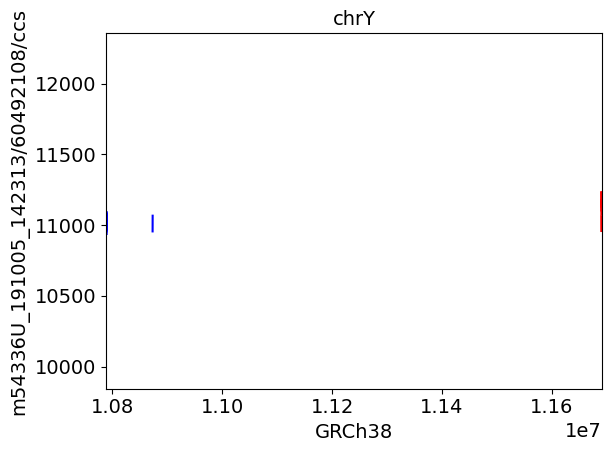

1


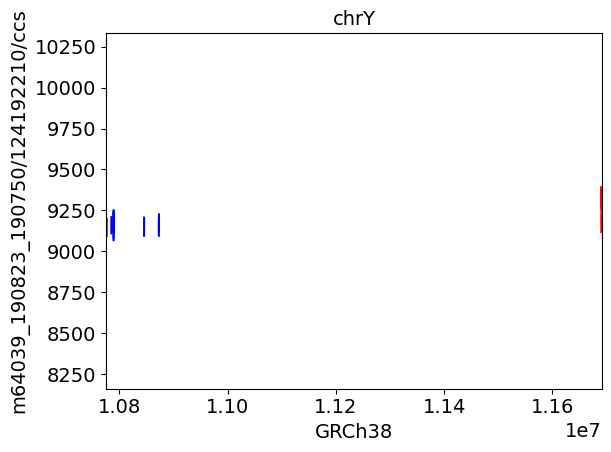

2


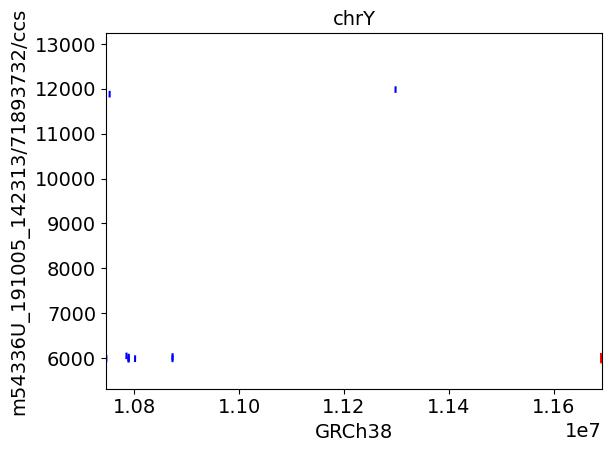

3


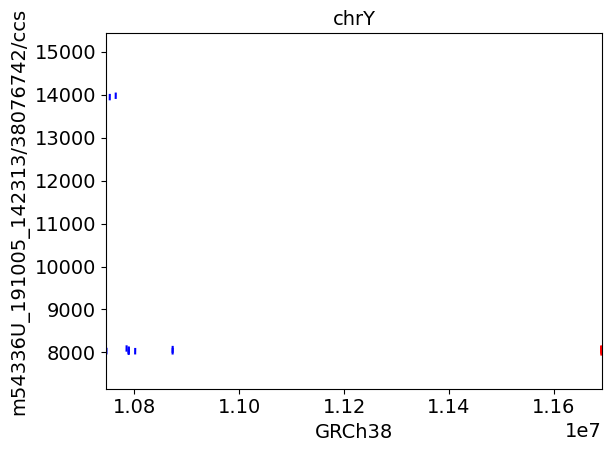

4


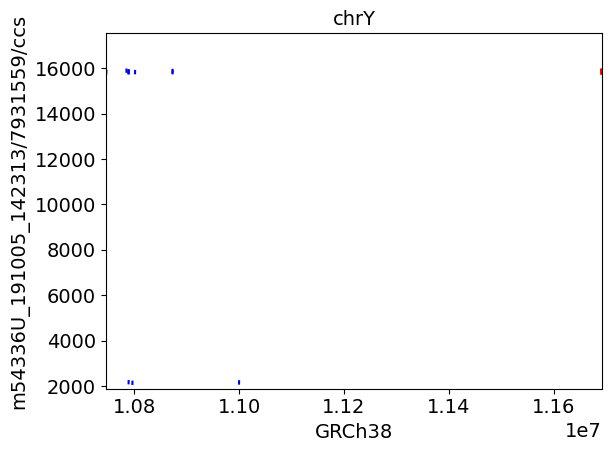

5


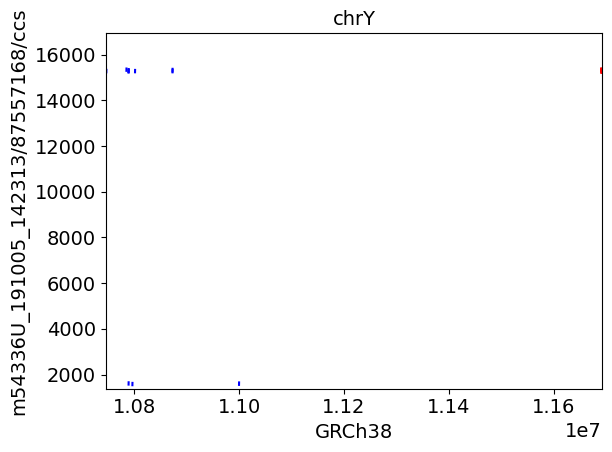

6


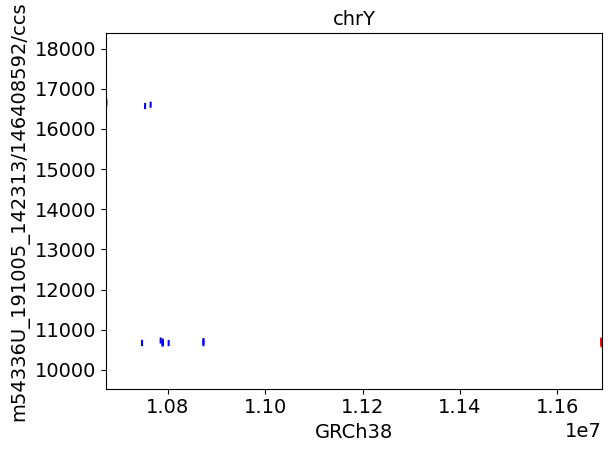

7


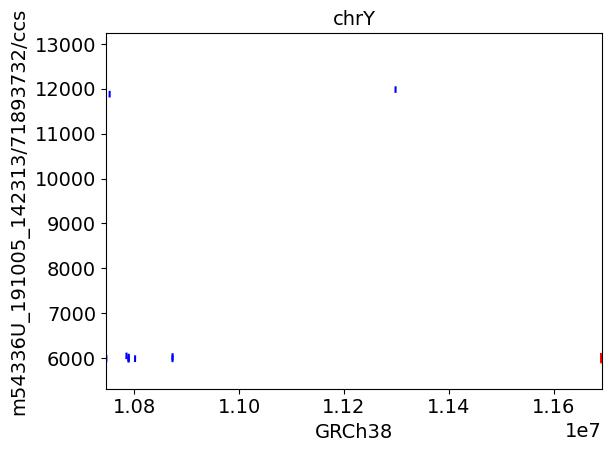

8


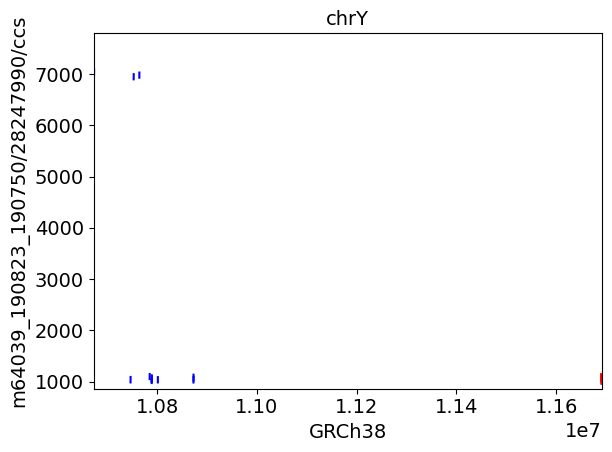

9


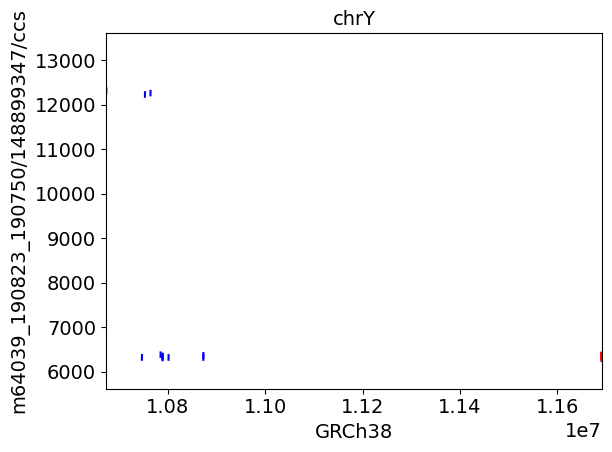

10


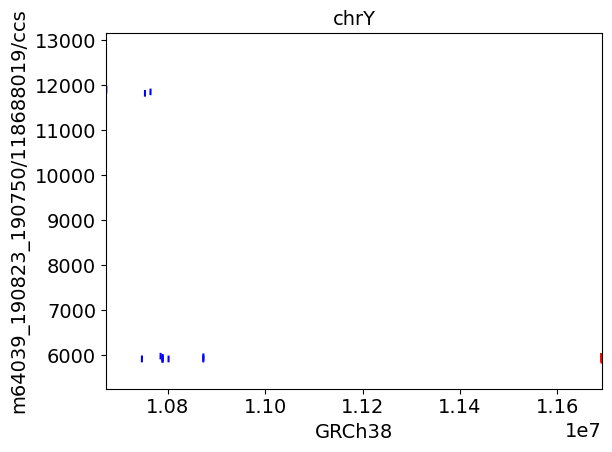

11


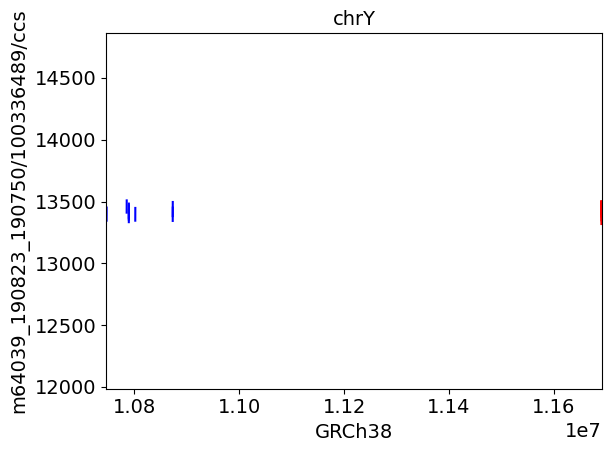

12


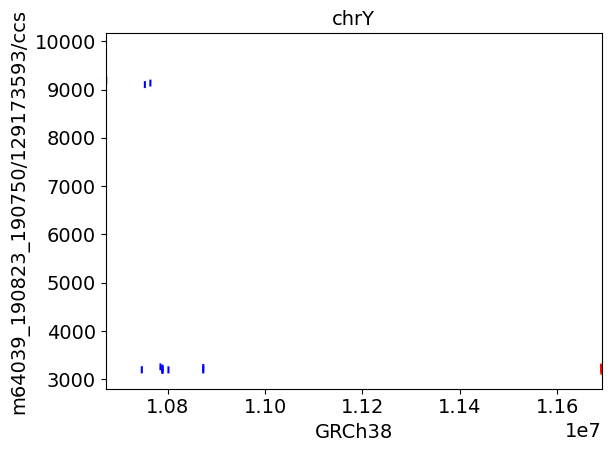

13


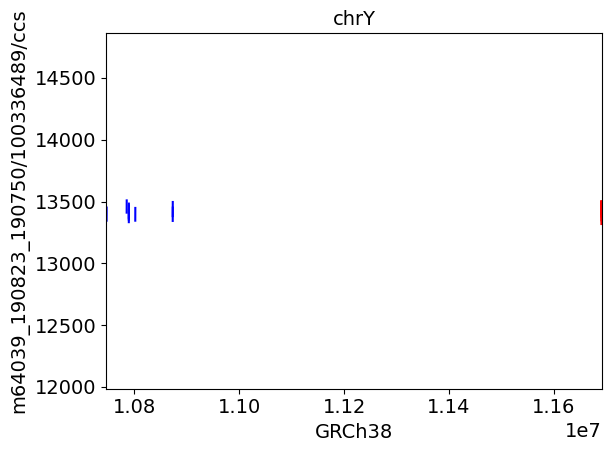

14


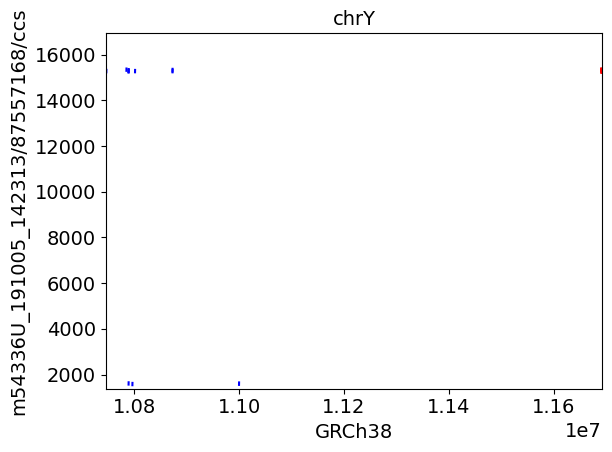

15


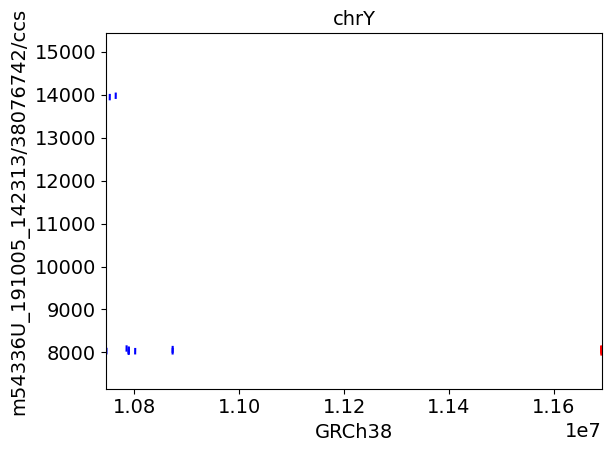

16


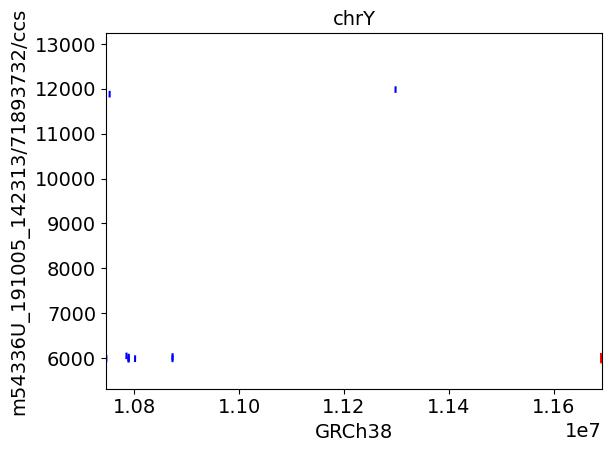

17


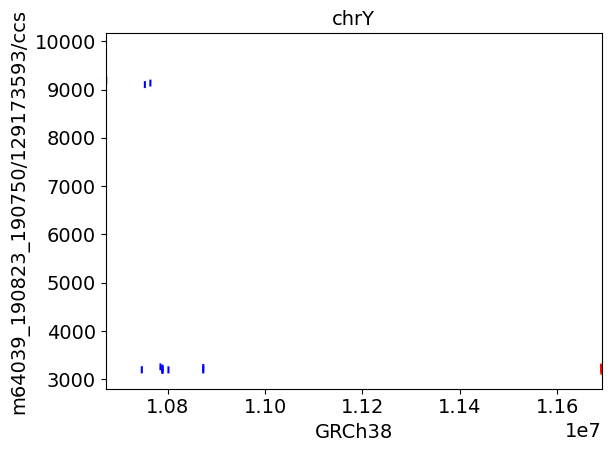

18


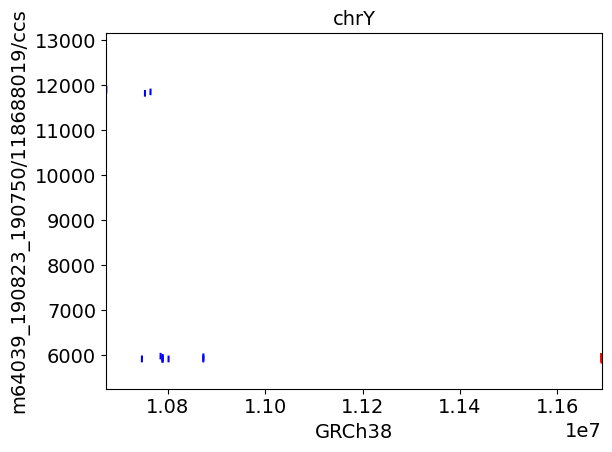

19


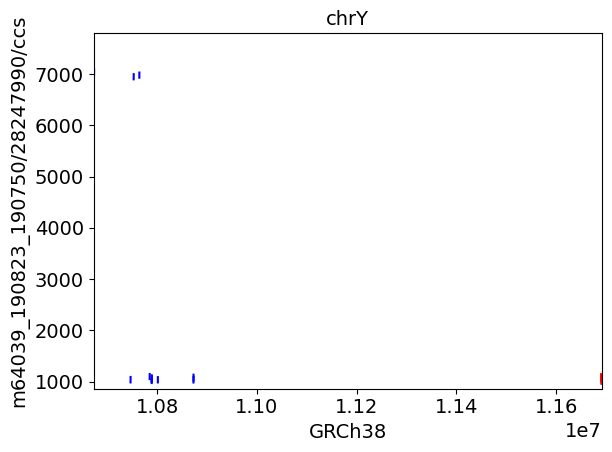

20


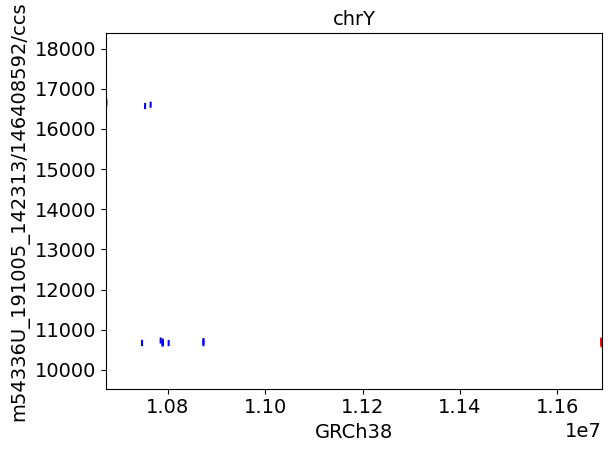

21


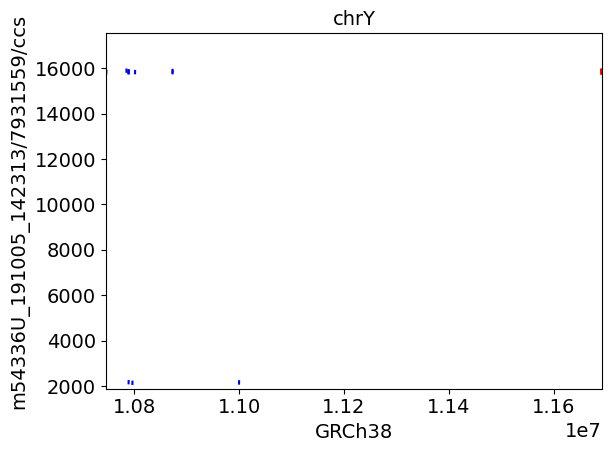

22


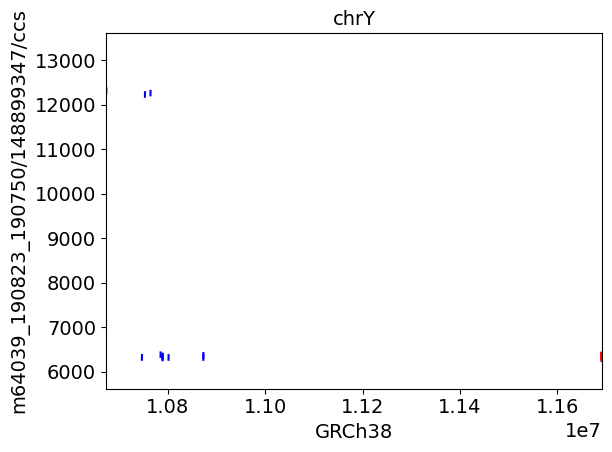

23


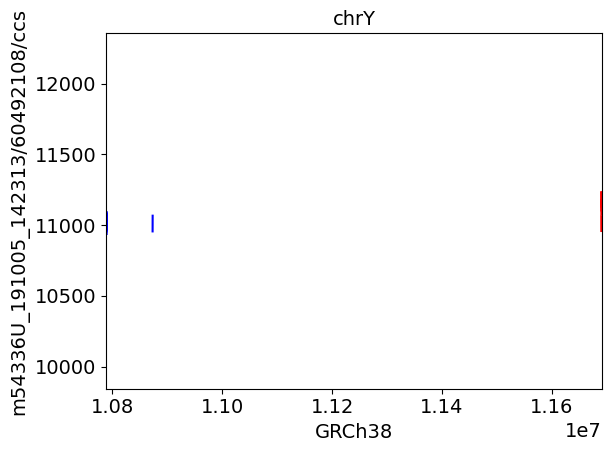

24


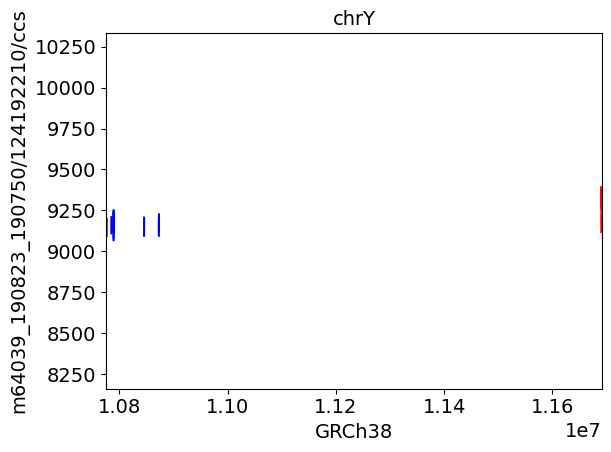

25


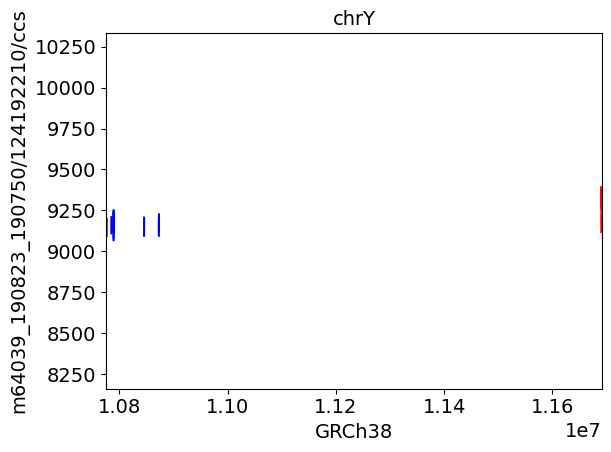

26


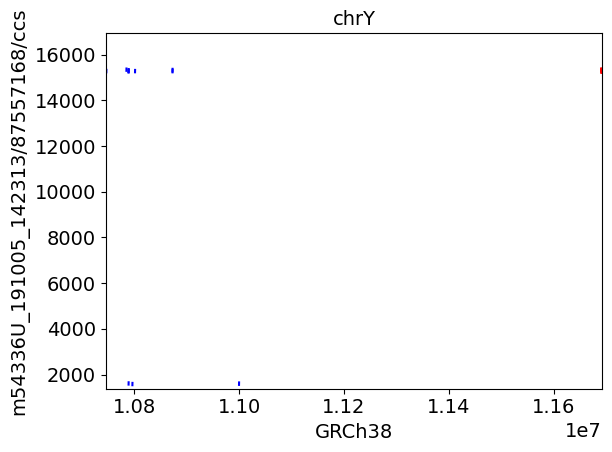

27


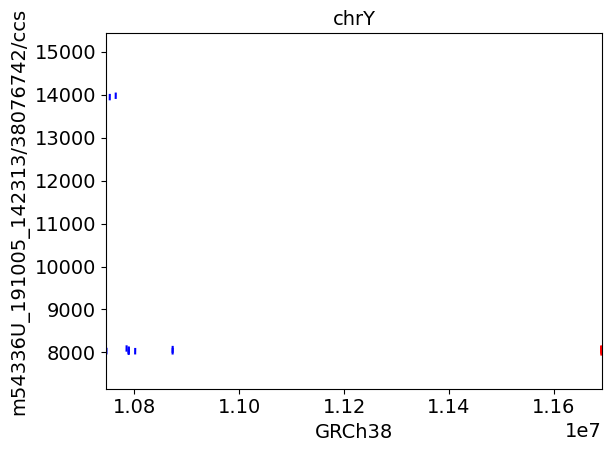

28


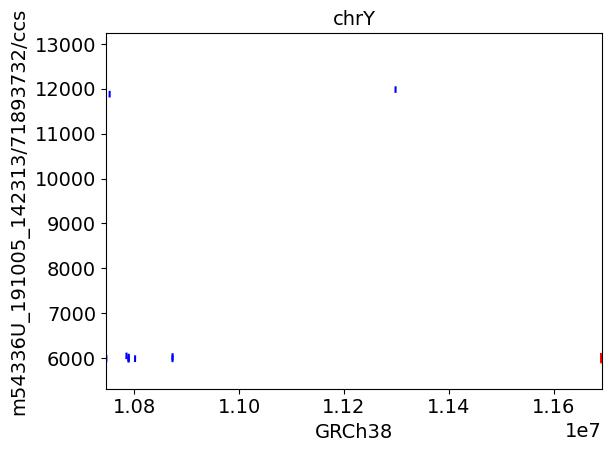

29


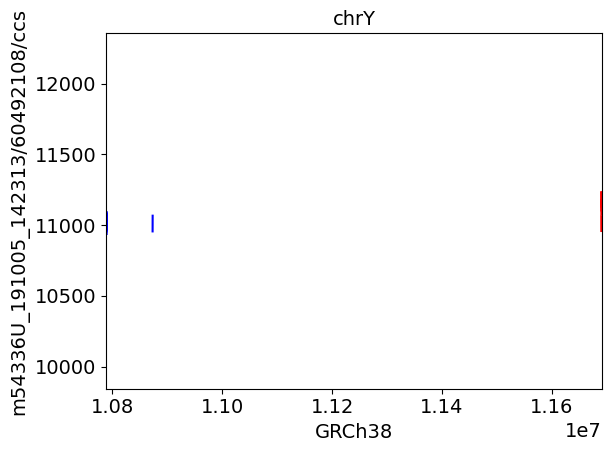

30


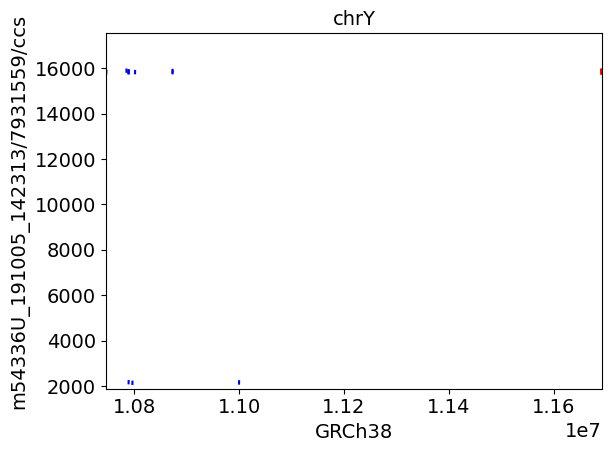

31


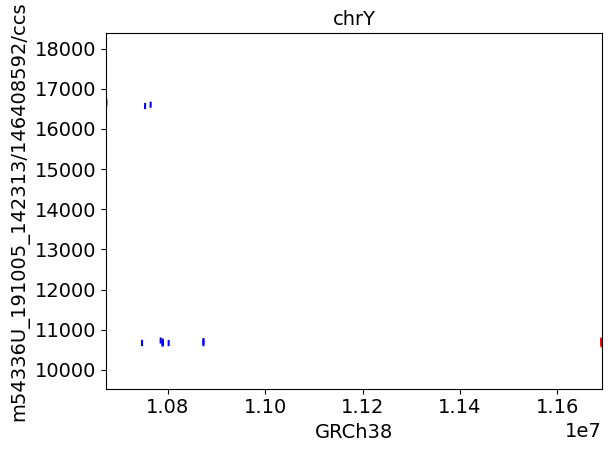

32


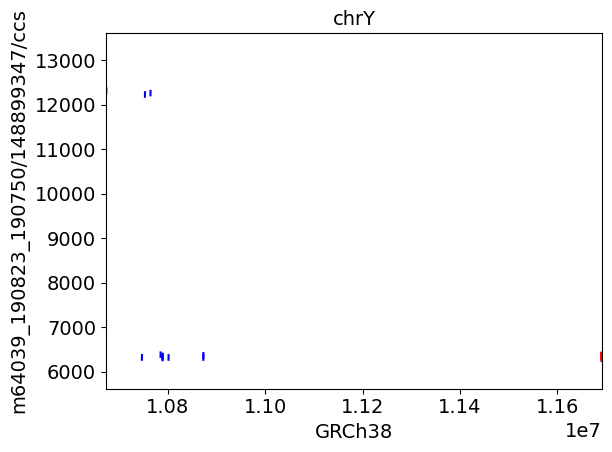

33


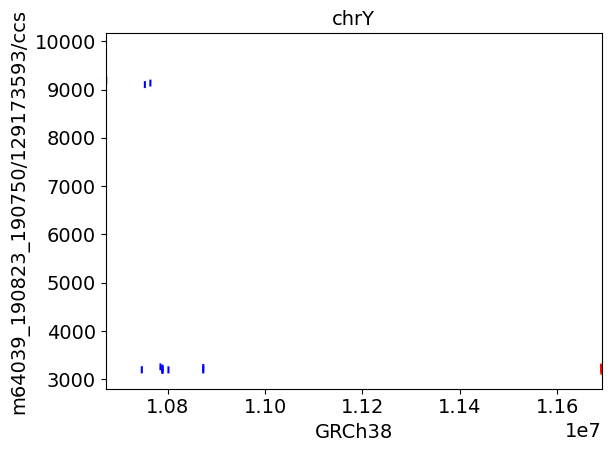

34


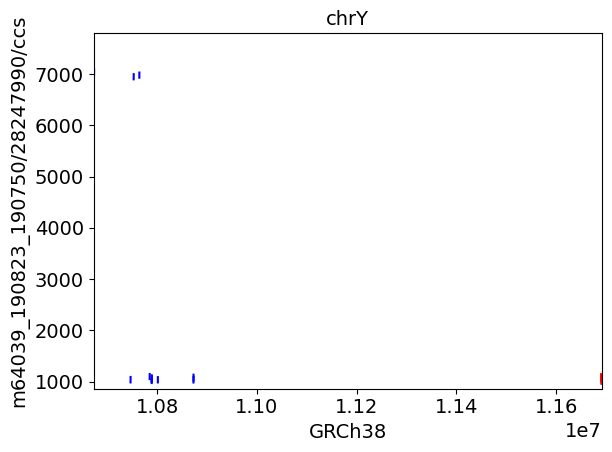

35


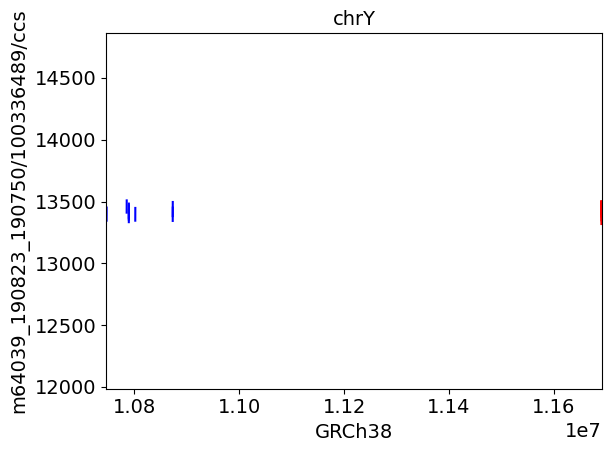

36


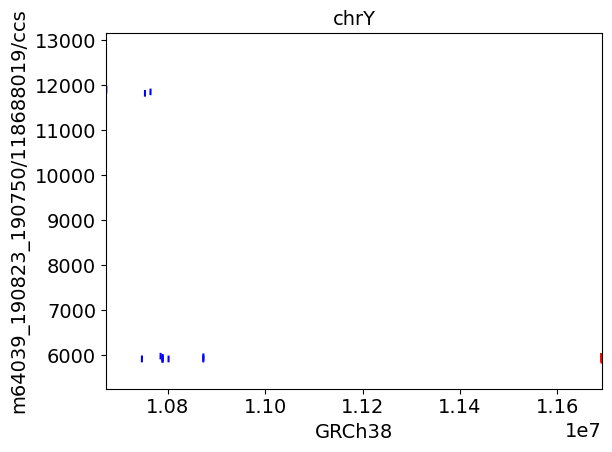

37


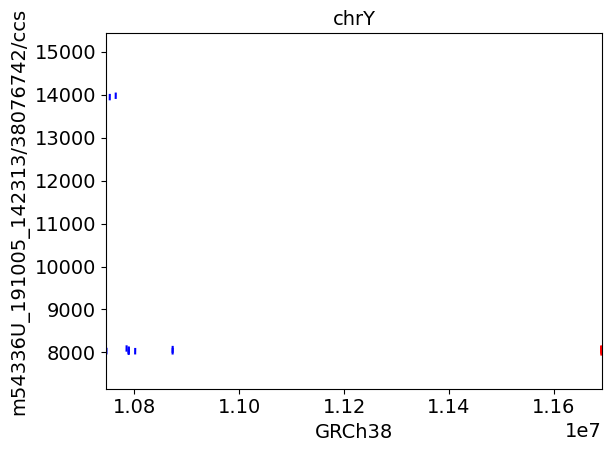

38


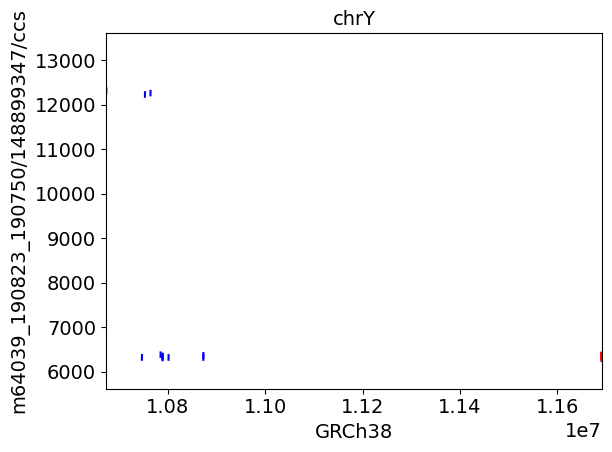

39


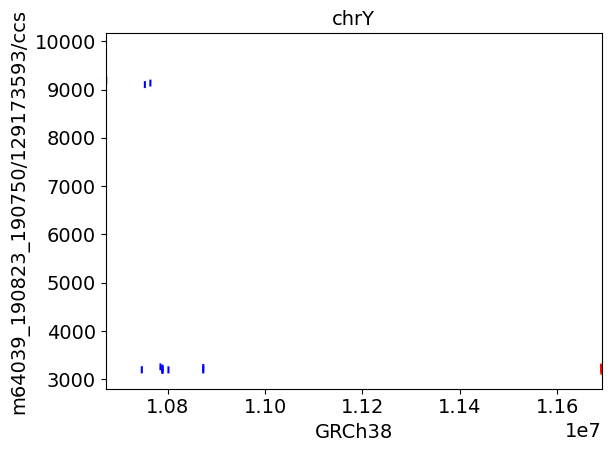

40


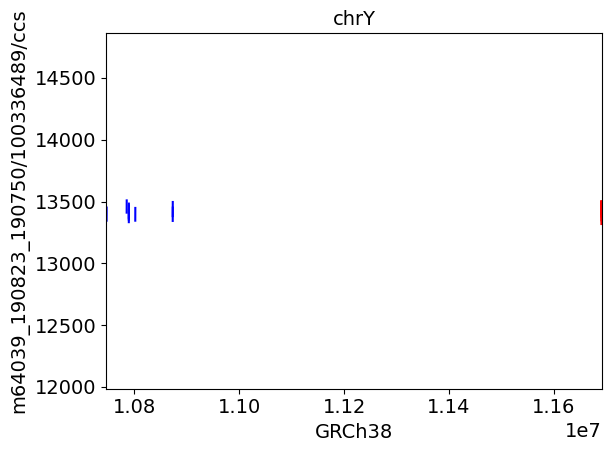

41


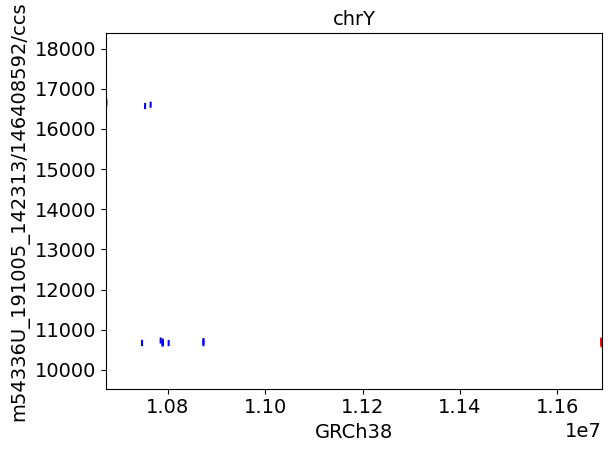

42


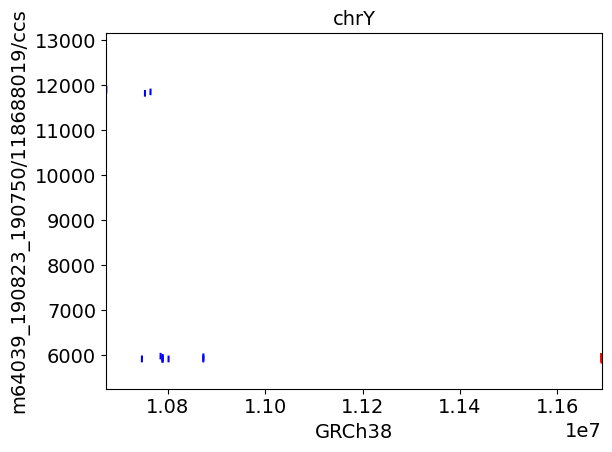

43


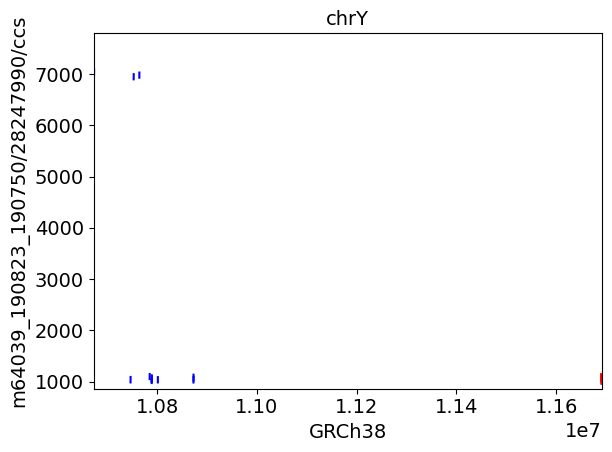

44


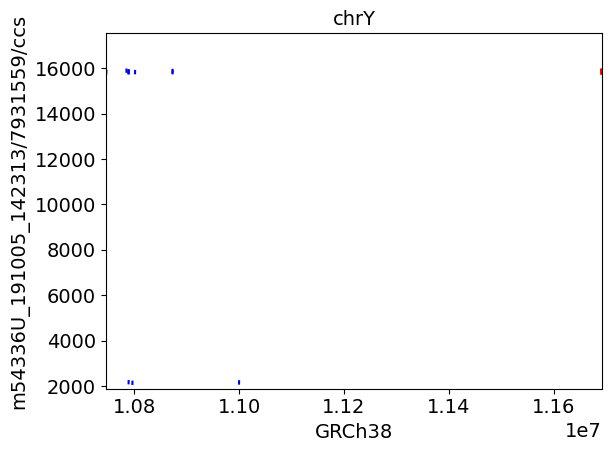

45


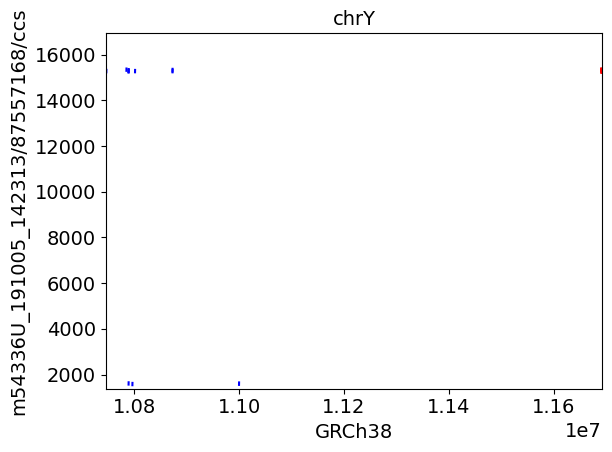

46


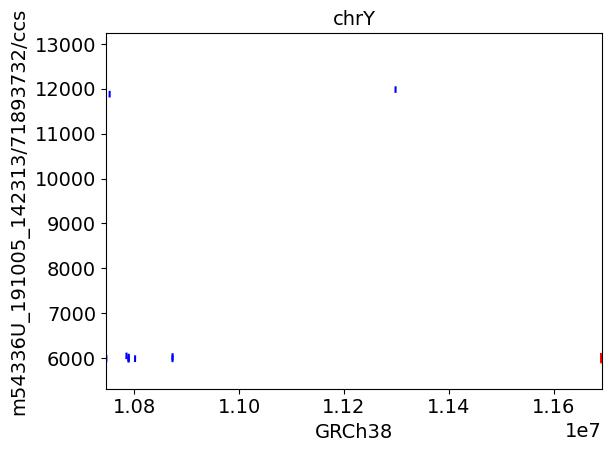

47


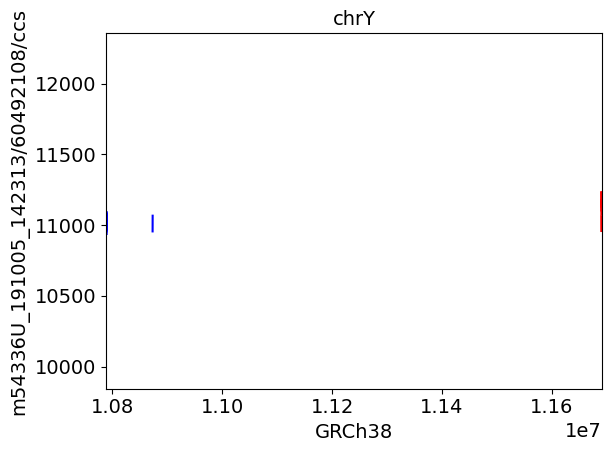

48


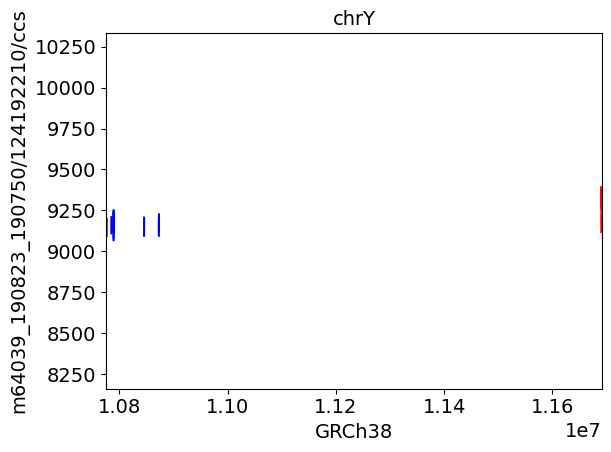

In [192]:
i = 0
for best_matches in read_sets:
    other_strand = "-"
    if (best_matches["strand"].iloc[0] == "-"):
        other_strand = "+"

    other_strand_matches = best_match_minus = variants[(variants["qname"] == best_matches["qname"].iloc[0]) & 
                                                       (variants["dname"] == best_matches["dname"].iloc[0]) & 
                                                       (variants["strand"] == other_strand)]
        
    other_strand_matches = other_strand_matches[~other_strand_matches["qbegin"].isin(best_matches["qbegin"])] 
    other_strand_matches = other_strand_matches[~other_strand_matches["qend"].isin(best_matches["qend"])]
    #print(other_strand_matches)
    if (len(other_strand_matches) > 0):
        print(i)
        plot_inversion(pd.concat([best_matches, other_strand_matches]))
    i += 1

In [170]:
pd.concat([best_matches, other_strand_matches])

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend,a,b
6601,chr5,49657017,49657073,98.2456,+,56,m64039_190830_040857/96403628/ccs,5366,5422,1.0,-49651651.0
6676,chr5,49658341,49658396,98.2142,+,55,m64039_190830_040857/96403628/ccs,6594,6649,1.0,-49651747.0
6720,chr5,49658868,49658923,98.2142,+,55,m64039_190830_040857/96403628/ccs,7170,7225,1.0,-49651698.0
6738,chr5,49659476,49659533,98.2758,+,57,m64039_190830_040857/96403628/ccs,7863,7920,1.0,-49651613.0
6763,chr5,49659563,49659626,98.4375,+,63,m64039_190830_040857/96403628/ccs,7870,7933,1.0,-49651693.0
6507,chr5,49601619,49601677,98.3050,-,58,m64039_190830_040857/96403628/ccs,6616,6674,1.0,-49595003.0
6508,chr5,49601619,49601677,98.3050,-,58,m64039_190830_040857/96403628/ccs,5874,5932,1.0,-49595745.0
6517,chr5,49602053,49602110,98.2758,-,57,m64039_190830_040857/96403628/ccs,8151,8208,1.0,-49593902.0


### Inversions from bash workflow

In [118]:
chr_id=4
read_id=5927

frames = []
strand = "plus"
for strand in ["plus", "minus"]:
    filename = "chr" + str(chr_id) + "_" + str(read_id) + "_" + strand + "_var.gff"
    frames.append(read_stellar_output(filename))

df = pd.concat(frames)
df

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
0,chr4,21582029,21582088,98.3333,+,59,m54329U_190906_205127/101581354/ccs,14165,14224
1,chr4,21582029,21582088,98.3333,+,59,m54329U_190906_205127/101581354/ccs,13861,13919
2,chr4,49633388,49633446,98.3050,+,58,m54329U_190906_205127/101581354/ccs,13869,13926
3,chr4,49633388,49633452,98.4615,+,64,m54329U_190906_205127/101581354/ccs,7698,7762
4,chr4,49633388,49633452,98.4615,+,64,m54329U_190906_205127/101581354/ccs,3683,3747
...,...,...,...,...,...,...,...,...,...
64,chr4,49149460,49149520,98.3606,-,60,m54329U_190906_205127/101581354/ccs,7072,7132
65,chr4,49149461,49149525,98.4615,-,64,m54329U_190906_205127/101581354/ccs,7698,7762
66,chr4,49150504,49150562,98.3050,-,58,m54329U_190906_205127/101581354/ccs,6453,6511
67,chr4,49154226,49154285,98.3333,-,59,m54329U_190906_205127/101581354/ccs,6452,6511


Clamp variable based on longest match

In [119]:
df = df[df["dbegin"] > 40000000]
plus = df[df["strand"] == "+"]
minus = df[df["strand"] == "-"]

In [120]:
print("Minus strand var range before clamp\t" + str(np.max(minus["dbegin"]) - np.min(minus["dbegin"])))
longest_match = minus[minus["len"] == np.max(minus["len"])]
min_begin = longest_match.dbegin.iloc[0] - int(longest_match.qbegin.iloc[0] * 1.5)
max_end = longest_match.dend.iloc[0] + int(longest_match.qend.iloc[0] * 1.5)
minus_best = minus[minus["dbegin"] > min_begin]
minus_best = minus_best[minus_best["dend"] < max_end]
print("Minus strand var range after clamp\t" + str(np.max(minus_best["dbegin"]) - np.min(minus_best["dbegin"])))

Minus strand var range before clamp	61664
Minus strand var range after clamp	16811


In [121]:
minus_best = minus_best[minus_best["len"] > 70]
minus_best

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
45,chr4,49138030,49138105,98.6842,-,75,m54329U_190906_205127/101581354/ccs,6072,6147


In [122]:
print("Plus strand var range before clamp\t" + str(np.max(plus["dbegin"]) - np.min(plus["dbegin"])))

Plus strand var range before clamp	18045


In [123]:
plus[plus["len"] == np.max(plus["len"])]

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
14,chr4,49635174,49635241,98.5294,+,67,m54329U_190906_205127/101581354/ccs,1188,1255
15,chr4,49635174,49635241,98.5294,+,67,m54329U_190906_205127/101581354/ccs,6456,6523
26,chr4,49639289,49639356,98.5294,+,67,m54329U_190906_205127/101581354/ccs,6452,6519


In [124]:
plus_best = plus[plus["len"] == np.max(plus["len"])].drop(15)
plus_best

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
14,chr4,49635174,49635241,98.5294,+,67,m54329U_190906_205127/101581354/ccs,1188,1255
26,chr4,49639289,49639356,98.5294,+,67,m54329U_190906_205127/101581354/ccs,6452,6519


In [125]:
print("Plus strand var range after clamp\t" + str(np.max(plus["dbegin"]) - np.min(plus["dbegin"])))

Plus strand var range after clamp	18045


In [126]:
a, b = line_params(plus_best)

In [127]:
y_line = [0, 14000]
x_line = []
for y in y_line:
    x_line.append((y - b) / a)
x_line

[49633986.0, 49647986.0]

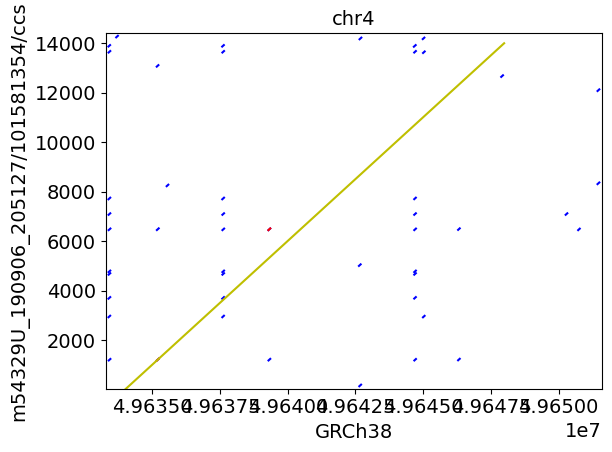

In [128]:
plot_matches_on_line(plus, plus_best, x_line, y_line)